# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [18]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [ x * 1e-8 for x in range(1, 100)]
regularization_strengths = [ x * 1e4 for x in range (8, 13)]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_acc = (y_train_pred == y_train).mean()
        val_acc = (y_val_pred == y_val).mean()
        if val_acc > best_val :
            best_val = val_acc
            best_svm = svm
        results[(lr, reg)] = (train_acc, val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 135.686203
iteration 100 / 1000: loss 100.968420
iteration 200 / 1000: loss 75.760231
iteration 300 / 1000: loss 57.473089
iteration 400 / 1000: loss 44.187311
iteration 500 / 1000: loss 34.548525
iteration 600 / 1000: loss 27.540630
iteration 700 / 1000: loss 22.457539
iteration 800 / 1000: loss 18.771405
iteration 900 / 1000: loss 16.097967
iteration 0 / 1000: loss 144.521482
iteration 100 / 1000: loss 103.530421
iteration 200 / 1000: loss 74.929149
iteration 300 / 1000: loss 54.985284
iteration 400 / 1000: loss 41.071265
iteration 500 / 1000: loss 31.365276
iteration 600 / 1000: loss 24.602543
iteration 700 / 1000: loss 19.879450
iteration 800 / 1000: loss 16.586797
iteration 900 / 1000: loss 14.290633
iteration 0 / 1000: loss 166.537059
iteration 100 / 1000: loss 114.563648
iteration 200 / 1000: loss 79.728533
iteration 300 / 1000: loss 56.393986
iteration 400 / 1000: loss 40.755059
iteration 500 / 1000: loss 30.274536
iteration 600 / 1000: loss 23.257584
i

iteration 800 / 1000: loss 8.999841
iteration 900 / 1000: loss 8.999809
iteration 0 / 1000: loss 174.279670
iteration 100 / 1000: loss 27.089424
iteration 200 / 1000: loss 10.978821
iteration 300 / 1000: loss 9.216929
iteration 400 / 1000: loss 9.023630
iteration 500 / 1000: loss 9.002430
iteration 600 / 1000: loss 9.000097
iteration 700 / 1000: loss 8.999873
iteration 800 / 1000: loss 8.999815
iteration 900 / 1000: loss 8.999847
iteration 0 / 1000: loss 187.095247
iteration 100 / 1000: loss 24.924047
iteration 200 / 1000: loss 10.423017
iteration 300 / 1000: loss 9.127102
iteration 400 / 1000: loss 9.011138
iteration 500 / 1000: loss 9.000875
iteration 600 / 1000: loss 8.999930
iteration 700 / 1000: loss 8.999857
iteration 800 / 1000: loss 8.999845
iteration 900 / 1000: loss 8.999863
iteration 0 / 1000: loss 139.716818
iteration 100 / 1000: loss 27.986626
iteration 200 / 1000: loss 11.760049
iteration 300 / 1000: loss 9.400575
iteration 400 / 1000: loss 9.058095
iteration 500 / 1000: 

iteration 900 / 1000: loss 8.999778
iteration 0 / 1000: loss 148.202819
iteration 100 / 1000: loss 12.677959
iteration 200 / 1000: loss 9.096886
iteration 300 / 1000: loss 9.002374
iteration 400 / 1000: loss 8.999875
iteration 500 / 1000: loss 8.999760
iteration 600 / 1000: loss 8.999776
iteration 700 / 1000: loss 8.999823
iteration 800 / 1000: loss 8.999809
iteration 900 / 1000: loss 8.999830
iteration 0 / 1000: loss 158.256169
iteration 100 / 1000: loss 11.625222
iteration 200 / 1000: loss 9.045927
iteration 300 / 1000: loss 9.000684
iteration 400 / 1000: loss 8.999831
iteration 500 / 1000: loss 8.999840
iteration 600 / 1000: loss 8.999833
iteration 700 / 1000: loss 8.999782
iteration 800 / 1000: loss 8.999847
iteration 900 / 1000: loss 8.999827
iteration 0 / 1000: loss 177.201994
iteration 100 / 1000: loss 10.965517
iteration 200 / 1000: loss 9.022858
iteration 300 / 1000: loss 9.000108
iteration 400 / 1000: loss 8.999860
iteration 500 / 1000: loss 8.999839
iteration 600 / 1000: los

iteration 0 / 1000: loss 206.761731
iteration 100 / 1000: loss 9.212341
iteration 200 / 1000: loss 9.000091
iteration 300 / 1000: loss 8.999849
iteration 400 / 1000: loss 8.999843
iteration 500 / 1000: loss 8.999861
iteration 600 / 1000: loss 8.999879
iteration 700 / 1000: loss 8.999848
iteration 800 / 1000: loss 8.999857
iteration 900 / 1000: loss 8.999881
iteration 0 / 1000: loss 131.960851
iteration 100 / 1000: loss 9.954321
iteration 200 / 1000: loss 9.007244
iteration 300 / 1000: loss 8.999860
iteration 400 / 1000: loss 8.999803
iteration 500 / 1000: loss 8.999807
iteration 600 / 1000: loss 8.999775
iteration 700 / 1000: loss 8.999813
iteration 800 / 1000: loss 8.999769
iteration 900 / 1000: loss 8.999818
iteration 0 / 1000: loss 150.908554
iteration 100 / 1000: loss 9.594826
iteration 200 / 1000: loss 9.002255
iteration 300 / 1000: loss 8.999847
iteration 400 / 1000: loss 8.999772
iteration 500 / 1000: loss 8.999797
iteration 600 / 1000: loss 8.999780
iteration 700 / 1000: loss 8

iteration 800 / 1000: loss 8.999835
iteration 900 / 1000: loss 8.999788
iteration 0 / 1000: loss 164.848228
iteration 100 / 1000: loss 9.067251
iteration 200 / 1000: loss 8.999818
iteration 300 / 1000: loss 8.999836
iteration 400 / 1000: loss 8.999847
iteration 500 / 1000: loss 8.999855
iteration 600 / 1000: loss 8.999824
iteration 700 / 1000: loss 8.999827
iteration 800 / 1000: loss 8.999781
iteration 900 / 1000: loss 8.999834
iteration 0 / 1000: loss 180.922535
iteration 100 / 1000: loss 9.033260
iteration 200 / 1000: loss 8.999842
iteration 300 / 1000: loss 8.999852
iteration 400 / 1000: loss 8.999837
iteration 500 / 1000: loss 8.999796
iteration 600 / 1000: loss 8.999857
iteration 700 / 1000: loss 8.999811
iteration 800 / 1000: loss 8.999855
iteration 900 / 1000: loss 8.999845
iteration 0 / 1000: loss 197.774109
iteration 100 / 1000: loss 9.016575
iteration 200 / 1000: loss 8.999842
iteration 300 / 1000: loss 8.999861
iteration 400 / 1000: loss 8.999841
iteration 500 / 1000: loss 8

iteration 900 / 1000: loss 8.999841
iteration 0 / 1000: loss 131.827182
iteration 100 / 1000: loss 9.048321
iteration 200 / 1000: loss 8.999806
iteration 300 / 1000: loss 8.999774
iteration 400 / 1000: loss 8.999756
iteration 500 / 1000: loss 8.999834
iteration 600 / 1000: loss 8.999750
iteration 700 / 1000: loss 8.999772
iteration 800 / 1000: loss 8.999783
iteration 900 / 1000: loss 8.999781
iteration 0 / 1000: loss 152.775548
iteration 100 / 1000: loss 9.020767
iteration 200 / 1000: loss 8.999813
iteration 300 / 1000: loss 8.999808
iteration 400 / 1000: loss 8.999813
iteration 500 / 1000: loss 8.999808
iteration 600 / 1000: loss 8.999787
iteration 700 / 1000: loss 8.999799
iteration 800 / 1000: loss 8.999798
iteration 900 / 1000: loss 8.999784
iteration 0 / 1000: loss 165.541904
iteration 100 / 1000: loss 9.008185
iteration 200 / 1000: loss 8.999807
iteration 300 / 1000: loss 8.999807
iteration 400 / 1000: loss 8.999843
iteration 500 / 1000: loss 8.999865
iteration 600 / 1000: loss 8

iteration 0 / 1000: loss 179.864816
iteration 100 / 1000: loss 9.000355
iteration 200 / 1000: loss 8.999839
iteration 300 / 1000: loss 8.999835
iteration 400 / 1000: loss 8.999828
iteration 500 / 1000: loss 8.999824
iteration 600 / 1000: loss 8.999858
iteration 700 / 1000: loss 8.999850
iteration 800 / 1000: loss 8.999831
iteration 900 / 1000: loss 8.999839
iteration 0 / 1000: loss 206.032510
iteration 100 / 1000: loss 9.000055
iteration 200 / 1000: loss 8.999869
iteration 300 / 1000: loss 8.999854
iteration 400 / 1000: loss 8.999844
iteration 500 / 1000: loss 8.999867
iteration 600 / 1000: loss 8.999863
iteration 700 / 1000: loss 8.999866
iteration 800 / 1000: loss 8.999858
iteration 900 / 1000: loss 8.999850
iteration 0 / 1000: loss 126.349582
iteration 100 / 1000: loss 9.008517
iteration 200 / 1000: loss 8.999797
iteration 300 / 1000: loss 8.999764
iteration 400 / 1000: loss 8.999808
iteration 500 / 1000: loss 8.999762
iteration 600 / 1000: loss 8.999746
iteration 700 / 1000: loss 8

iteration 900 / 1000: loss 8.999789
iteration 0 / 1000: loss 148.482311
iteration 100 / 1000: loss 9.000508
iteration 200 / 1000: loss 8.999800
iteration 300 / 1000: loss 8.999781
iteration 400 / 1000: loss 8.999807
iteration 500 / 1000: loss 8.999840
iteration 600 / 1000: loss 8.999809
iteration 700 / 1000: loss 8.999825
iteration 800 / 1000: loss 8.999748
iteration 900 / 1000: loss 8.999818
iteration 0 / 1000: loss 161.174684
iteration 100 / 1000: loss 8.999998
iteration 200 / 1000: loss 8.999809
iteration 300 / 1000: loss 8.999818
iteration 400 / 1000: loss 8.999807
iteration 500 / 1000: loss 8.999833
iteration 600 / 1000: loss 8.999834
iteration 700 / 1000: loss 8.999869
iteration 800 / 1000: loss 8.999846
iteration 900 / 1000: loss 8.999839
iteration 0 / 1000: loss 182.208328
iteration 100 / 1000: loss 8.999905
iteration 200 / 1000: loss 8.999811
iteration 300 / 1000: loss 8.999877
iteration 400 / 1000: loss 8.999828
iteration 500 / 1000: loss 8.999865
iteration 600 / 1000: loss 8

iteration 100 / 1000: loss 8.999869
iteration 200 / 1000: loss 8.999868
iteration 300 / 1000: loss 8.999879
iteration 400 / 1000: loss 8.999843
iteration 500 / 1000: loss 8.999868
iteration 600 / 1000: loss 8.999864
iteration 700 / 1000: loss 8.999858
iteration 800 / 1000: loss 8.999858
iteration 900 / 1000: loss 8.999874
iteration 0 / 1000: loss 129.639739
iteration 100 / 1000: loss 9.000194
iteration 200 / 1000: loss 8.999761
iteration 300 / 1000: loss 8.999784
iteration 400 / 1000: loss 8.999789
iteration 500 / 1000: loss 8.999795
iteration 600 / 1000: loss 8.999786
iteration 700 / 1000: loss 8.999796
iteration 800 / 1000: loss 8.999782
iteration 900 / 1000: loss 8.999847
iteration 0 / 1000: loss 153.812060
iteration 100 / 1000: loss 8.999921
iteration 200 / 1000: loss 8.999775
iteration 300 / 1000: loss 8.999820
iteration 400 / 1000: loss 8.999856
iteration 500 / 1000: loss 8.999829
iteration 600 / 1000: loss 8.999836
iteration 700 / 1000: loss 8.999810
iteration 800 / 1000: loss 8

iteration 900 / 1000: loss 8.999793
iteration 0 / 1000: loss 172.663386
iteration 100 / 1000: loss 8.999834
iteration 200 / 1000: loss 8.999836
iteration 300 / 1000: loss 8.999815
iteration 400 / 1000: loss 8.999841
iteration 500 / 1000: loss 8.999822
iteration 600 / 1000: loss 8.999800
iteration 700 / 1000: loss 8.999816
iteration 800 / 1000: loss 8.999859
iteration 900 / 1000: loss 8.999806
iteration 0 / 1000: loss 174.364194
iteration 100 / 1000: loss 8.999832
iteration 200 / 1000: loss 8.999829
iteration 300 / 1000: loss 8.999826
iteration 400 / 1000: loss 8.999865
iteration 500 / 1000: loss 8.999836
iteration 600 / 1000: loss 8.999857
iteration 700 / 1000: loss 8.999857
iteration 800 / 1000: loss 8.999852
iteration 900 / 1000: loss 8.999856
iteration 0 / 1000: loss 188.332582
iteration 100 / 1000: loss 8.999832
iteration 200 / 1000: loss 8.999859
iteration 300 / 1000: loss 8.999885
iteration 400 / 1000: loss 8.999846
iteration 500 / 1000: loss 8.999838
iteration 600 / 1000: loss 8

iteration 100 / 1000: loss 8.999837
iteration 200 / 1000: loss 8.999759
iteration 300 / 1000: loss 8.999790
iteration 400 / 1000: loss 8.999775
iteration 500 / 1000: loss 8.999810
iteration 600 / 1000: loss 8.999813
iteration 700 / 1000: loss 8.999746
iteration 800 / 1000: loss 8.999805
iteration 900 / 1000: loss 8.999782
iteration 0 / 1000: loss 158.991382
iteration 100 / 1000: loss 8.999804
iteration 200 / 1000: loss 8.999816
iteration 300 / 1000: loss 8.999790
iteration 400 / 1000: loss 8.999845
iteration 500 / 1000: loss 8.999727
iteration 600 / 1000: loss 8.999809
iteration 700 / 1000: loss 8.999798
iteration 800 / 1000: loss 8.999790
iteration 900 / 1000: loss 8.999813
iteration 0 / 1000: loss 160.186599
iteration 100 / 1000: loss 8.999839
iteration 200 / 1000: loss 8.999874
iteration 300 / 1000: loss 8.999827
iteration 400 / 1000: loss 8.999853
iteration 500 / 1000: loss 8.999840
iteration 600 / 1000: loss 8.999844
iteration 700 / 1000: loss 8.999820
iteration 800 / 1000: loss 8

iteration 300 / 1000: loss 8.999867
iteration 400 / 1000: loss 8.999841
iteration 500 / 1000: loss 8.999835
iteration 600 / 1000: loss 8.999849
iteration 700 / 1000: loss 8.999826
iteration 800 / 1000: loss 8.999821
iteration 900 / 1000: loss 8.999829
iteration 0 / 1000: loss 195.816509
iteration 100 / 1000: loss 8.999851
iteration 200 / 1000: loss 8.999851
iteration 300 / 1000: loss 8.999891
iteration 400 / 1000: loss 8.999873
iteration 500 / 1000: loss 8.999874
iteration 600 / 1000: loss 8.999862
iteration 700 / 1000: loss 8.999846
iteration 800 / 1000: loss 8.999837
iteration 900 / 1000: loss 8.999877
iteration 0 / 1000: loss 127.434597
iteration 100 / 1000: loss 8.999795
iteration 200 / 1000: loss 8.999780
iteration 300 / 1000: loss 8.999813
iteration 400 / 1000: loss 8.999755
iteration 500 / 1000: loss 8.999807
iteration 600 / 1000: loss 8.999827
iteration 700 / 1000: loss 8.999742
iteration 800 / 1000: loss 8.999798
iteration 900 / 1000: loss 8.999787
iteration 0 / 1000: loss 154

iteration 300 / 1000: loss 8.999798
iteration 400 / 1000: loss 8.999793
iteration 500 / 1000: loss 8.999764
iteration 600 / 1000: loss 8.999800
iteration 700 / 1000: loss 8.999784
iteration 800 / 1000: loss 8.999834
iteration 900 / 1000: loss 8.999802
iteration 0 / 1000: loss 165.200810
iteration 100 / 1000: loss 8.999822
iteration 200 / 1000: loss 8.999845
iteration 300 / 1000: loss 8.999840
iteration 400 / 1000: loss 8.999834
iteration 500 / 1000: loss 8.999843
iteration 600 / 1000: loss 8.999866
iteration 700 / 1000: loss 8.999835
iteration 800 / 1000: loss 8.999825
iteration 900 / 1000: loss 8.999800
iteration 0 / 1000: loss 181.203982
iteration 100 / 1000: loss 8.999867
iteration 200 / 1000: loss 8.999840
iteration 300 / 1000: loss 8.999844
iteration 400 / 1000: loss 8.999820
iteration 500 / 1000: loss 8.999829
iteration 600 / 1000: loss 8.999850
iteration 700 / 1000: loss 8.999862
iteration 800 / 1000: loss 8.999854
iteration 900 / 1000: loss 8.999843
iteration 0 / 1000: loss 190

iteration 200 / 1000: loss 8.999860
iteration 300 / 1000: loss 8.999856
iteration 400 / 1000: loss 8.999865
iteration 500 / 1000: loss 8.999855
iteration 600 / 1000: loss 8.999854
iteration 700 / 1000: loss 8.999870
iteration 800 / 1000: loss 8.999842
iteration 900 / 1000: loss 8.999840
iteration 0 / 1000: loss 138.820418
iteration 100 / 1000: loss 8.999811
iteration 200 / 1000: loss 8.999761
iteration 300 / 1000: loss 8.999786
iteration 400 / 1000: loss 8.999826
iteration 500 / 1000: loss 8.999812
iteration 600 / 1000: loss 8.999793
iteration 700 / 1000: loss 8.999792
iteration 800 / 1000: loss 8.999816
iteration 900 / 1000: loss 8.999802
iteration 0 / 1000: loss 150.369333
iteration 100 / 1000: loss 8.999848
iteration 200 / 1000: loss 8.999852
iteration 300 / 1000: loss 8.999783
iteration 400 / 1000: loss 8.999788
iteration 500 / 1000: loss 8.999826
iteration 600 / 1000: loss 8.999827
iteration 700 / 1000: loss 8.999833
iteration 800 / 1000: loss 8.999835
iteration 900 / 1000: loss 8

iteration 200 / 1000: loss 8.999810
iteration 300 / 1000: loss 8.999855
iteration 400 / 1000: loss 8.999834
iteration 500 / 1000: loss 8.999828
iteration 600 / 1000: loss 8.999829
iteration 700 / 1000: loss 8.999820
iteration 800 / 1000: loss 8.999820
iteration 900 / 1000: loss 8.999851
iteration 0 / 1000: loss 169.088077
iteration 100 / 1000: loss 8.999879
iteration 200 / 1000: loss 8.999881
iteration 300 / 1000: loss 8.999867
iteration 400 / 1000: loss 8.999873
iteration 500 / 1000: loss 8.999836
iteration 600 / 1000: loss 8.999848
iteration 700 / 1000: loss 8.999804
iteration 800 / 1000: loss 8.999833
iteration 900 / 1000: loss 8.999858
iteration 0 / 1000: loss 186.663203
iteration 100 / 1000: loss 8.999862
iteration 200 / 1000: loss 8.999843
iteration 300 / 1000: loss 8.999848
iteration 400 / 1000: loss 8.999836
iteration 500 / 1000: loss 8.999864
iteration 600 / 1000: loss 8.999864
iteration 700 / 1000: loss 8.999864
iteration 800 / 1000: loss 8.999876
iteration 900 / 1000: loss 8

iteration 400 / 1000: loss 8.999851
iteration 500 / 1000: loss 8.999727
iteration 600 / 1000: loss 8.999775
iteration 700 / 1000: loss 8.999812
iteration 800 / 1000: loss 8.999797
iteration 900 / 1000: loss 8.999768
iteration 0 / 1000: loss 143.194054
iteration 100 / 1000: loss 8.999804
iteration 200 / 1000: loss 8.999831
iteration 300 / 1000: loss 8.999823
iteration 400 / 1000: loss 8.999812
iteration 500 / 1000: loss 8.999843
iteration 600 / 1000: loss 8.999838
iteration 700 / 1000: loss 8.999824
iteration 800 / 1000: loss 8.999835
iteration 900 / 1000: loss 8.999829
iteration 0 / 1000: loss 167.457878
iteration 100 / 1000: loss 8.999835
iteration 200 / 1000: loss 8.999849
iteration 300 / 1000: loss 8.999851
iteration 400 / 1000: loss 8.999825
iteration 500 / 1000: loss 8.999802
iteration 600 / 1000: loss 8.999873
iteration 700 / 1000: loss 8.999846
iteration 800 / 1000: loss 8.999809
iteration 900 / 1000: loss 8.999784
iteration 0 / 1000: loss 182.521819
iteration 100 / 1000: loss 8

iteration 600 / 1000: loss 8.999851
iteration 700 / 1000: loss 8.999864
iteration 800 / 1000: loss 8.999883
iteration 900 / 1000: loss 8.999822
iteration 0 / 1000: loss 194.125755
iteration 100 / 1000: loss 8.999880
iteration 200 / 1000: loss 8.999837
iteration 300 / 1000: loss 8.999850
iteration 400 / 1000: loss 8.999878
iteration 500 / 1000: loss 8.999874
iteration 600 / 1000: loss 8.999868
iteration 700 / 1000: loss 8.999840
iteration 800 / 1000: loss 8.999858
iteration 900 / 1000: loss 8.999868
iteration 0 / 1000: loss 130.444915
iteration 100 / 1000: loss 8.999768
iteration 200 / 1000: loss 8.999817
iteration 300 / 1000: loss 8.999827
iteration 400 / 1000: loss 8.999770
iteration 500 / 1000: loss 8.999822
iteration 600 / 1000: loss 8.999786
iteration 700 / 1000: loss 8.999770
iteration 800 / 1000: loss 8.999821
iteration 900 / 1000: loss 8.999761
iteration 0 / 1000: loss 151.071040
iteration 100 / 1000: loss 8.999817
iteration 200 / 1000: loss 8.999789
iteration 300 / 1000: loss 8

iteration 600 / 1000: loss 8.999840
iteration 700 / 1000: loss 8.999820
iteration 800 / 1000: loss 8.999827
iteration 900 / 1000: loss 8.999782
iteration 0 / 1000: loss 168.338873
iteration 100 / 1000: loss 8.999831
iteration 200 / 1000: loss 8.999859
iteration 300 / 1000: loss 8.999868
iteration 400 / 1000: loss 8.999826
iteration 500 / 1000: loss 8.999841
iteration 600 / 1000: loss 8.999885
iteration 700 / 1000: loss 8.999824
iteration 800 / 1000: loss 8.999839
iteration 900 / 1000: loss 8.999840
iteration 0 / 1000: loss 172.738262
iteration 100 / 1000: loss 8.999863
iteration 200 / 1000: loss 8.999857
iteration 300 / 1000: loss 8.999817
iteration 400 / 1000: loss 8.999842
iteration 500 / 1000: loss 8.999829
iteration 600 / 1000: loss 8.999867
iteration 700 / 1000: loss 8.999858
iteration 800 / 1000: loss 8.999836
iteration 900 / 1000: loss 8.999861
iteration 0 / 1000: loss 184.237676
iteration 100 / 1000: loss 8.999868
iteration 200 / 1000: loss 8.999883
iteration 300 / 1000: loss 8

iteration 600 / 1000: loss 8.999863
iteration 700 / 1000: loss 8.999876
iteration 800 / 1000: loss 8.999863
iteration 900 / 1000: loss 8.999864
iteration 0 / 1000: loss 132.139153
iteration 100 / 1000: loss 8.999794
iteration 200 / 1000: loss 8.999799
iteration 300 / 1000: loss 8.999821
iteration 400 / 1000: loss 8.999816
iteration 500 / 1000: loss 8.999790
iteration 600 / 1000: loss 8.999825
iteration 700 / 1000: loss 8.999802
iteration 800 / 1000: loss 8.999800
iteration 900 / 1000: loss 8.999783
iteration 0 / 1000: loss 154.781301
iteration 100 / 1000: loss 8.999793
iteration 200 / 1000: loss 8.999857
iteration 300 / 1000: loss 8.999823
iteration 400 / 1000: loss 8.999846
iteration 500 / 1000: loss 8.999786
iteration 600 / 1000: loss 8.999816
iteration 700 / 1000: loss 8.999803
iteration 800 / 1000: loss 8.999854
iteration 900 / 1000: loss 8.999825
iteration 0 / 1000: loss 162.387279
iteration 100 / 1000: loss 8.999835
iteration 200 / 1000: loss 8.999804
iteration 300 / 1000: loss 8

iteration 900 / 1000: loss 8.999867
iteration 0 / 1000: loss 186.077906
iteration 100 / 1000: loss 8.999885
iteration 200 / 1000: loss 8.999860
iteration 300 / 1000: loss 8.999865
iteration 400 / 1000: loss 8.999883
iteration 500 / 1000: loss 8.999834
iteration 600 / 1000: loss 8.999862
iteration 700 / 1000: loss 8.999838
iteration 800 / 1000: loss 8.999817
iteration 900 / 1000: loss 8.999888
iteration 0 / 1000: loss 188.949605
iteration 100 / 1000: loss 8.999875
iteration 200 / 1000: loss 8.999861
iteration 300 / 1000: loss 8.999860
iteration 400 / 1000: loss 8.999853
iteration 500 / 1000: loss 8.999849
iteration 600 / 1000: loss 8.999853
iteration 700 / 1000: loss 8.999876
iteration 800 / 1000: loss 8.999881
iteration 900 / 1000: loss 8.999845
iteration 0 / 1000: loss 130.932919
iteration 100 / 1000: loss 8.999786
iteration 200 / 1000: loss 8.999825
iteration 300 / 1000: loss 8.999779
iteration 400 / 1000: loss 8.999795
iteration 500 / 1000: loss 8.999810
iteration 600 / 1000: loss 8

iteration 900 / 1000: loss 8.999788
iteration 0 / 1000: loss 148.306182
iteration 100 / 1000: loss 8.999832
iteration 200 / 1000: loss 8.999802
iteration 300 / 1000: loss 8.999835
iteration 400 / 1000: loss 8.999823
iteration 500 / 1000: loss 8.999847
iteration 600 / 1000: loss 8.999801
iteration 700 / 1000: loss 8.999754
iteration 800 / 1000: loss 8.999838
iteration 900 / 1000: loss 8.999821
iteration 0 / 1000: loss 161.822322
iteration 100 / 1000: loss 8.999824
iteration 200 / 1000: loss 8.999861
iteration 300 / 1000: loss 8.999820
iteration 400 / 1000: loss 8.999808
iteration 500 / 1000: loss 8.999840
iteration 600 / 1000: loss 8.999822
iteration 700 / 1000: loss 8.999807
iteration 800 / 1000: loss 8.999846
iteration 900 / 1000: loss 8.999806
iteration 0 / 1000: loss 185.231351
iteration 100 / 1000: loss 8.999874
iteration 200 / 1000: loss 8.999845
iteration 300 / 1000: loss 8.999841
iteration 400 / 1000: loss 8.999855
iteration 500 / 1000: loss 8.999874
iteration 600 / 1000: loss 8

iteration 700 / 1000: loss 8.999844
iteration 800 / 1000: loss 8.999841
iteration 900 / 1000: loss 8.999873
iteration 0 / 1000: loss 197.604077
iteration 100 / 1000: loss 8.999899
iteration 200 / 1000: loss 8.999864
iteration 300 / 1000: loss 8.999876
iteration 400 / 1000: loss 8.999877
iteration 500 / 1000: loss 8.999862
iteration 600 / 1000: loss 8.999848
iteration 700 / 1000: loss 8.999868
iteration 800 / 1000: loss 8.999847
iteration 900 / 1000: loss 8.999831
iteration 0 / 1000: loss 134.276164
iteration 100 / 1000: loss 8.999784
iteration 200 / 1000: loss 8.999780
iteration 300 / 1000: loss 8.999797
iteration 400 / 1000: loss 8.999832
iteration 500 / 1000: loss 8.999785
iteration 600 / 1000: loss 8.999796
iteration 700 / 1000: loss 8.999760
iteration 800 / 1000: loss 8.999777
iteration 900 / 1000: loss 8.999837
iteration 0 / 1000: loss 150.477544
iteration 100 / 1000: loss 8.999801
iteration 200 / 1000: loss 8.999834
iteration 300 / 1000: loss 8.999839
iteration 400 / 1000: loss 8

In [19]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


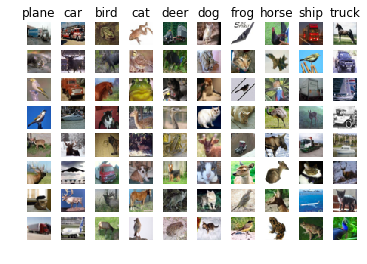

In [20]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [21]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [39]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_val = -1
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [x * 1e-2 for x in range(35, 50)]
regularization_strengths = [5e-7, 5e-6, 5e-5, 5e-4]

#for lr in learning_rates:
#    for reg in regularization_strengths:
for reg in regularization_strengths:
    for lr in learning_rates:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                 learning_rate=lr, reg=reg, num_iters=1000)
        loss_hist = stats['loss_history']
        train_acc = stats['train_acc_history'][-1]
        val_acc = stats['val_acc_history'][-1]
        
        '''
        plt.subplot(2, 1, 1)
        plt.plot(loss_hist)
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        
        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.legend()
        plt.show()
        '''
        
        if val_acc > best_val:
            best_val = val_acc
            best_net = net
        
        print('lr %e reg %e loss: %f to %f train_acc: %f val_acc: %f' % (
            lr, reg, loss_hist[0], loss_hist[-1], train_acc, val_acc))

print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 3.500000e-01 reg 5.000000e-07 loss: 2.302585 to 1.052685 train_acc: 0.725000 val_acc: 0.575000
lr 3.600000e-01 reg 5.000000e-07 loss: 2.302585 to 1.077653 train_acc: 0.675000 val_acc: 0.556000
lr 3.700000e-01 reg 5.000000e-07 loss: 2.302585 to 1.122975 train_acc: 0.715000 val_acc: 0.569000
lr 3.800000e-01 reg 5.000000e-07 loss: 2.302585 to 1.045865 train_acc: 0.710000 val_acc: 0.565000
lr 3.900000e-01 reg 5.000000e-07 loss: 2.302585 to 1.087970 train_acc: 0.770000 val_acc: 0.570000
lr 4.000000e-01 reg 5.000000e-07 loss: 2.302585 to 1.057187 train_acc: 0.740000 val_acc: 0.567000
lr 4.100000e-01 reg 5.000000e-07 loss: 2.302585 to 1.059137 train_acc: 0.765000 val_acc: 0.547000
lr 4.200000e-01 reg 5.000000e-07 loss: 2.302585 to 1.154193 train_acc: 0.755000 val_acc: 0.564000
lr 4.300000e-01 reg 5.000000e-07 loss: 2.302585 to 1.034047 train_acc: 0.745000 val_acc: 0.581000
lr 4.400000e-01 reg 5.000000e-07 loss: 2.302585 to 1.003919 train_acc: 0.750000 val_acc: 0.580000
lr 4.500000e-01 reg 

In [40]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.564
